In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as n

In [4]:
from neuron import h
from neuron.units import ms, mV
h.load_file('stdrun.hoc')
nA = 1
A = 1e9

V = 1e3

In [5]:
h.steps_per_ms = 128
h.run()

Changed dt


0.0

In [6]:
def make_IClamp(loc, params):
    stimulus = h.IClamp(loc)
    stimulus.delay = params['stim_delay']
    stimulus.dur = params['stim_dur']
    stimulus.amp = params['stim_amp_nA']
    return stimulus

class Ball:
    def __init__(self,cell_id, params):
        self.cell_id = cell_id
        self.params = params
        self.init_shape() 
        self.init_biophysics()

    def init_shape(self):
        self.soma = h.Section(name='soma', cell=self)
        self.soma.L = self.params['soma_L']
        self.soma.diam = self.params['soma_diam']
#         self.all = [self.soma]
        if self.params.get('dend', 0) > 0:
            self.dends = []
            assert len(self.params['dend_conns']) == self.params['dend']
            for i in range(self.params['dend']):
                self.dends.append(h.Section(name='dend_{}'.format(i)))
                self.dends[i].L = self.params['dend_L']
                self.dends[i].diam = self.params['dend_diam']
                self.dends[i].nseg = self.params['dend_nseg']
                if self.params['dend_conns'][i] == 's':
                    self.dends[i].connect(self.soma)
                else:
                    self.dends[i].connect(self.dends[self.params['dend_conns'][i]])
#                 self.all.append(self.dends[i])
        self.all = self.soma.wholetree()
    
    def init_biophysics(self ):
        
        for sec in self.all:
            sec.Ra = self.params['all_Ra'] # Axial resistance in Ohm * cm      
            sec.cm = self.params['all_cm'] # Membrane capacitance in micro Farads / cm^2
        
        
        self.soma.insert('pas')
        for seg in self.soma:
            seg.pas.g = self.params['soma_g']
            seg.pas.e = self.params['soma_e']
            pass
        
        if self.params.get('soma_hh', None) is not None:
            assert False, "not implemented"
            self.soma.insert('hh')                                                    # <-- NEW           
            for seg in self.soma:                                                     # <-- NEW
                seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2                   # <-- NEW
                seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2                # <-- NEW
                seg.hh.gl = 0.0003    # Leak conductance in S/cm2                     # <-- NEW
                seg.hh.el = -54.3     # Reversal potential in mV                      # <-- NEW
    
    def __repr__(self):
        return 'Ball_{}'.format(self.cell_id)

In [7]:
def analyze_stim(data, stim, verbose = True):
    stim_start = int(h.steps_per_ms * stim.delay)
    stim_end = int(h.steps_per_ms * (stim.delay + stim.dur))
    stim_waveform = data[stim_start:stim_end]
    
    tau_m = calculate_tau(stim_waveform)
    r_i = calculate_ri(stim_waveform, stim.amp)
    
    if verbose: print("tau_m: {:.2f} secs\nr_i: {:.2f} Gohms".format(tau_m, r_i))
    
    return {'tau_m' : tau_m, 'r_i' : r_i}

def calculate_tau(stim_waveform):
    rising = (stim_waveform[-1] > stim_waveform[0])
    hi = stim_waveform.max()
    lo = stim_waveform.min()
    rng = hi - lo
    if rising: point = n.where(stim_waveform > (lo + rng*0.63))[0][0]
    else: point = n.where(stim_waveform < (lo + rng*0.37))[0][0]
    tau = point * h.dt
    return tau

def calculate_ri(stim_waveform, amplitude_nA):
    hi = stim_waveform.max()
    lo = stim_waveform.min()
    rng = hi - lo
    
    # range (rng) is in mV
    # amplitude is in nA
    # r_i is in Gohms
    r_i = rng / (amplitude_nA)
    return r_i

In [8]:
def param_sweep(params, stimulus_params, param_sweeps, run_dur_ms = 20):
    
    results = {}

    for parameter in param_sweeps.keys():
        params_n = params.copy()
        stimulus_params_n = stimulus_params.copy()  
        param_values = param_sweeps[parameter]
        results[parameter] = n.zeros((3, len(param_values)))
        results[parameter + '_raw'] = []
        i = 0
        for param_val in param_values:
            params_n[parameter] = param_val
    #         print(params_n)
            ball = Ball(0,params_n)
            
            stim_1Dcoord = stimulus_params['stim_loc'][2]
            if stimulus_params['stim_loc'][0] == 'soma':
                stimulus = make_IClamp(ball.soma(stim_1Dcoord), stimulus_params_n)
            elif stimulus_params['stim_loc'][0] == 'dend':
                dend_id = stimulus_params['stim_loc'][1]
                stimulus = make_IClamp(ball.dends[dend_id](stim_1Dcoord), stimulus_params_n)

            
            recordings = []
            for sec in ball.all:
                recordings.append(h.Vector().record(sec(0.5)._ref_v))
            
            t = h.Vector().record(h._ref_t)

            h.finitialize(params_n['soma_e'] * mV)
            h.continuerun(run_dur_ms * ms)

            vs = n.array(recordings[0])
            ts = n.array(t)

            res = analyze_stim(vs, stimulus, verbose = False)

            tau_m = res['tau_m']
            r_i = res['r_i']
            results[parameter][0,i] = param_val
            results[parameter][1,i] = tau_m
            results[parameter][2,i] = r_i
            
            
            raw_dict = {'t' : ts}
            j = 0
            for sec in ball.all:
                raw_dict[sec.name()] = n.array(recordings[j])
                j += 1
            results[parameter + '_raw'].append(raw_dict)

            i += 1
    return results

def plot_sweep(results, param, plotfunc = None):
    
    
    
    title = "Sweeping param: {}".format(param)
    res = results[param]
    f, ax1 = plt.subplots()
    
    ax1.set_ylabel("tau_m (sec)")
    ax1.set_xlabel("{}".format(param))
    if plotfunc is None:
        ax1.plot(res[0], res[1], label='tau_m', color='blue')
    elif plotfunc == 'semilogx':
        ax1.semilogx(res[0], res[1], label='tau_m', color='blue')
        
    ax2 = ax1.twinx()
    ax2.set_ylabel("r_i (Gohms)")
    if plotfunc is None:
        ax2.plot(res[0], res[2], label='r_i', color='red')
    elif plotfunc == 'semilogx':
        ax2.semilogx(res[0], res[2], label='r_i', color='red')
    
    ax1.legend()
    ax2.legend()
    return f
    
def plot_multiple_recordings(result_dict, title=None, plot_which = 'all'):
    time = result_dict['t']
    for key in result_dict.keys():
        if key == 't': continue
        if plot_which != 'all':
            if key not in plot_which: continue
        plt.plot(time, result_dict[key], label = key)
    plt.legend()
    

### 1. Make a ball model and measure Ri, mTau with current injection

In [9]:
params = {'soma_L' : 12.615, 'soma_diam' : 12.615, 
          'all_Ra' : 100, 'all_cm' : 1, 'soma_g' : 0.001, 'soma_e' : -65}
stimulus_params = {'stim_delay' : 1, 'stim_dur' : 10, 'stim_amp_nA' : 0.01}
ball = Ball(0,params)

In [10]:
stimulus = make_IClamp(ball.soma(0.5), stimulus_params)

soma_v = h.Vector().record(ball.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

h.finitialize(params['soma_e'] * mV)
h.continuerun(20 * ms)

vs = n.array(soma_v)
ts = n.array(t)

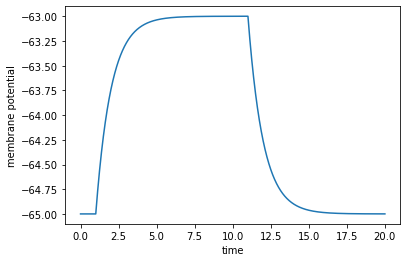

In [13]:
plt.plot(ts, vs)
# plt.xlim(0.99,1.01)

plt.xlabel('time')
plt.ylabel('membrane potential')
plt.show()

In [14]:
analyze_stim(vs, stimulus)

tau_m: 1.00 secs
r_i: 200.01 Gohms


{'tau_m': 1.0, 'r_i': 200.011496251242}

### 2. Change diameter, Rm, Ra, Cm and see how it affects Ri and mTau

In [15]:
param_sweeps = {
    'soma_diam' : n.linspace(5, 50, 50),
    'all_Ra' : [1, 5, 10, 50, 100, 500, 1000],
    'all_cm' : (n.linspace(0, 50, 50)),
    'soma_g'  : n.linspace(0.0001, 0.01, 50)
}
stimulus_params = {'stim_delay' : 1, 'stim_dur' : 50, 'stim_amp_nA' : 0.01, 'stim_loc' : ('soma', 0, 0.5)}

In [16]:
results = param_sweep(params, stimulus_params, param_sweeps, run_dur_ms = 53)

#### Cm effects

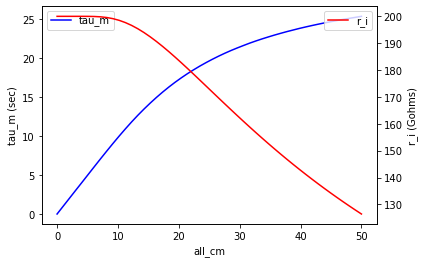

In [17]:
plot_sweep(results, 'all_cm');

Careful - if you increase Cm too far, the time constant is comparable to stim duration, so the calculation breaks down! 

In [18]:
cm_sweep = {'all_cm' : (n.linspace(0, 3,200))}
results_cm_only = param_sweep(params, stimulus_params, cm_sweep, run_dur_ms = 53)

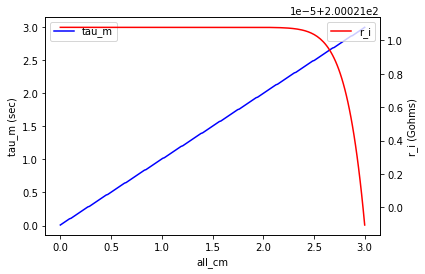

In [19]:
plot_sweep(results_cm_only, 'all_cm');
# plt.xlim(0,2)

#### Ra effects

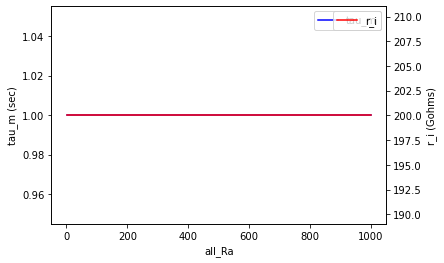

In [20]:
plot_sweep(results, 'all_Ra');

#### Rm (g) effects

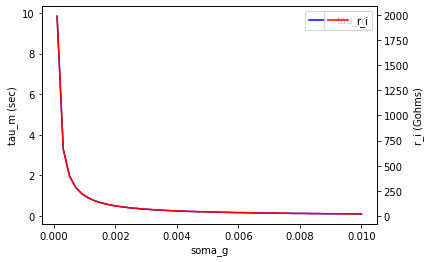

In [21]:
plot_sweep(results, 'soma_g');

#### diameter effects

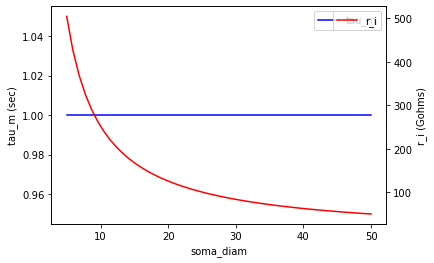

In [22]:
plot_sweep(results, 'soma_diam');

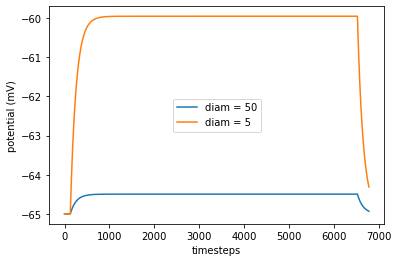

In [23]:
plt.plot(results['soma_diam_raw'][-1]['Ball_0.soma'], label ='diam = 50')
plt.plot(results['soma_diam_raw'][0]['Ball_0.soma'], label='diam = 5')
plt.xlabel('timesteps')

plt.ylabel('potential (mV)')
plt.legend()

### Add dendrites and axons of increasing total areas. What happens to Ri and mTau? Pay special attention to whether mTau is a single exponential.

In [24]:
params_dend = {'soma_L' : 12.615,          # soma length
               'soma_diam' : 12.615,       # soma diameter
               'all_Ra' : 500,             # axial resistance of all sections
               'all_cm' : 1,               # membrane capacitance of cell
               'soma_g' : 0.001,           # soma conductance
               'soma_e' : -65,             # soma rest potential
               'dend' : 4,                 # number of dendrites
               'dend_L' : 15,             # length of dendrites
               'dend_diam' : 1,            # diameter of dendrites
               'dend_nseg' : 11,
               'dend_conns' : ['s', 's', 1, 1]  # where each dendrite is connected to. 's' indicates soma, 
                                                # integer indicates index of another dendrite.
              
              }
stimulus_params = {'stim_delay' : 1,       # number of ms before stimulus onset
                   'stim_dur' : 50,        # duration of stimulus (mS)
                   'stim_amp_nA' : 0.01,   # current in nA
                   'stim_loc' : ('dend', 3, 0.5)} # location of stimulus. [0] is type of section, 
                                                  # [1] is ID of section (e.g. if there are multiple dendrites)
                                                  # [2] is coordinate along the section between 0 and 1
# dend_cell = Ball(0,params_dend)

/home/ali/anaconda3/envs/neuron-sim/lib/python3.8/site-packages/neuron/__init__.py:744: MatplotlibDeprecationWarning: Setting the line's pick radius via set_picker is deprecated since 3.3 and will be removed two minor releases later; use set_pickradius instead.
  line, = self.plot(xs, ys, zs, '-', **kwargs)


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

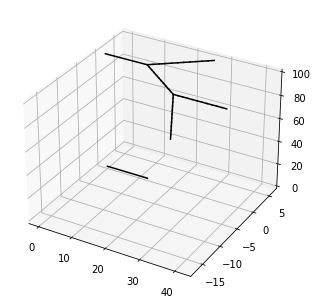

In [25]:
# if you have made other cells in this session, it will plot them all which is somewhat annoying
dend_cell = Ball(0,params_dend)
h.PlotShape(False).plot(plt);

In [43]:
params_dends_sweep = {'dend_diam' : n.linspace(1, 10, 100)}


In [44]:
dend_results = param_sweep(params_dend, stimulus_params, params_dends_sweep )

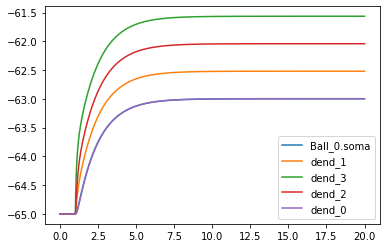

In [47]:
plot_multiple_recordings(dend_results['dend_diam_raw'][0])

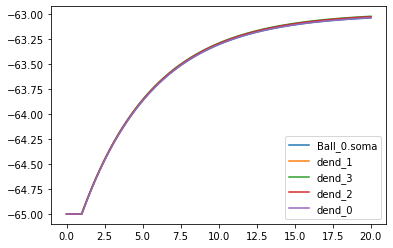

In [48]:

plot_multiple_recordings(dend_results['dend_diam_raw'][-1])

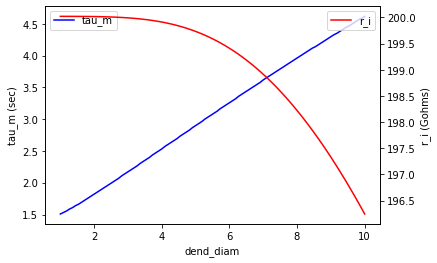

In [29]:
plot_sweep(dend_results, 'dend_diam');

In [30]:
params_dends_sweep = {'dend_L' : n.linspace(1, 50, 100)}

In [37]:
dend_results = param_sweep(params_dend, stimulus_params, params_dends_sweep ,run_dur_ms=60)


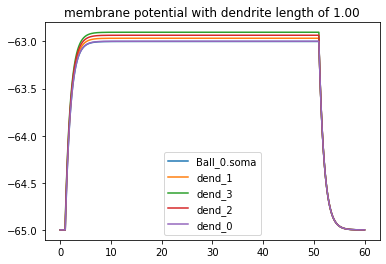

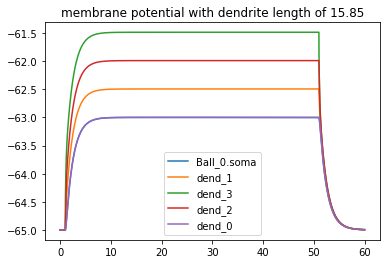

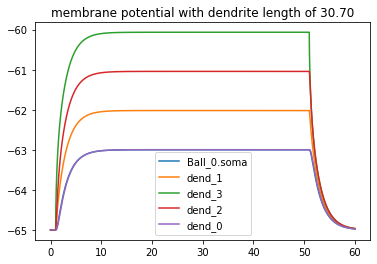

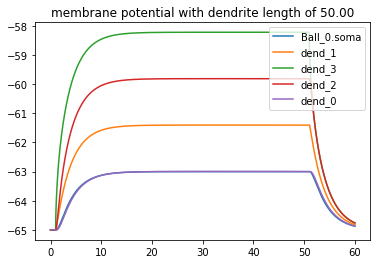

In [40]:
plot_multiple_recordings(dend_results['dend_L_raw'][0])
plt.title("membrane potential with dendrite length of {:.2f}".format(params_dends_sweep['dend_L'][0]))
plt.show()
plot_multiple_recordings(dend_results['dend_L_raw'][30])
plt.title("membrane potential with dendrite length of {:.2f}".format(params_dends_sweep['dend_L'][30]))
plt.show()
plot_multiple_recordings(dend_results['dend_L_raw'][60])
plt.title("membrane potential with dendrite length of {:.2f}".format(params_dends_sweep['dend_L'][60]))
plt.show()
plot_multiple_recordings(dend_results['dend_L_raw'][99])
plt.title("membrane potential with dendrite length of {:.2f}".format(params_dends_sweep['dend_L'][99]))
plt.show()

Text(0.5, 1.0, 'change in tau_m and r_i as a function of dendrite length')

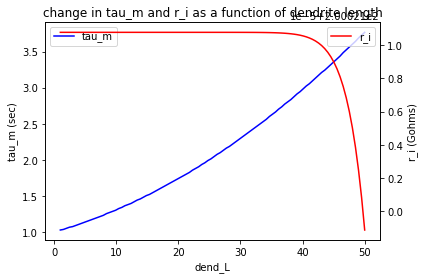

In [35]:
plot_sweep(dend_results, 'dend_L');
plt.title("change in tau_m and r_i as a function of dendrite length")

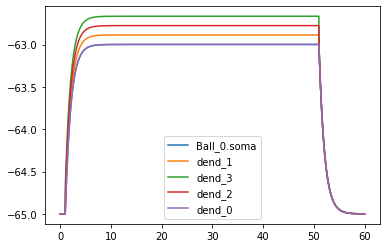

In [33]:
plot_multiple_recordings(dend_results['dend_L_raw'][5])